## Use the ProcessWordle Module

In [1]:
from importlib import reload
from ProcessWordle import ScrabblePoints, ParseWordle
import censoring

In [7]:
sp = ScrabblePoints(censoring.wordle_answers_input)
sp.read_wordle_answers()
sp.add_total_and_difficulty()

pw = ParseWordle(
    censoring.raw_whatsapp_input, 
    censoring.wordle_output,
    censoring.name_alias
)
pw.create_wordle_df()
pw.process_data_frame()
pw.join_data_frames(sp.words_df)
pw.write_final_df()

## Import Modules for PYMC

In [1]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import censoring

RANDOM_SEED = 100
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

## Load Data

In [2]:
# load data
df = pd.read_csv(censoring.wordle_output)

## One more layer of processing

It turns out that if someone does not participate, then they will have a lower score (lower rate of fails) then someone who did particpate.
Thus, the contest should only be around puzzles which have equal contributions. 

In [3]:
# limit to the puzzle in which we last have words
df2 = df[ (df['PuzzleNum'] < 528) & 
         (df['PuzzleNum'] != 421) & 
         (df['Difficulty'] != 'Undefined')
        ].copy()

### Reshape data to move players/difficulty to columns

In [4]:
alias_list = [ censoring.name_alias[i] for i in [*censoring.name_alias]]
# create dummy dataset for predictors
playerDummies = pd.get_dummies(df2['Name'])
difficultyDummies = pd.get_dummies(df2['Difficulty'])
# create dummy dataset for interactions
template = np.zeros((len(playerDummies.index), 8*2))
c = 0
interaction_list = []
for i in playerDummies.columns: 
    for j in difficultyDummies.columns:
        new_vector = playerDummies[i].values * difficultyDummies[j].values
        template[:, c] = new_vector
        interaction_list.append(i + '_' + j)
        c += 1
        
interactionDummies = pd.DataFrame(template, columns=interaction_list)

## Model
The 'players' are treated as one-hot encoded columns. This allows me to make predicions by using pm.set_data(). But is it worth it? 

Should I be adding a 'puzzle' dimension, here? 
Need to double-check which variables I am pooling / not-pooling. From a conceptual standpoint, each player should be independent, but difficulty should not be independent?

In [5]:
with pm.Model(
    coords={
        "obs": df2.index.values, 
        "Player": playerDummies.columns,
        "Difficulty": difficultyDummies.columns,
        "PlayerDifficulty": interactionDummies.columns
    }
) as BB2:
    
    # using pm.data
    y = pm.MutableData("y", df2['Fails'].to_numpy())
    xPlayers = pm.MutableData("xPlayers", playerDummies.to_numpy())
    xDifficulty = pm.MutableData("xDifficulty", difficultyDummies.to_numpy())
    xInteraction = pm.MutableData("xInteraction", interactionDummies.to_numpy())
    
    # Names
    Namesβ = pm.HalfNormal("Namesβ", sigma=1, dims="Player")

    # Difficulty
    Diffβ = pm.HalfNormal("Diffβ", sigma=1, dims="Difficulty")

    # Interaction
    Interβ = pm.HalfNormal("Interβ", sigma=1, dims="PlayerDifficulty")
    
    # Error
    ϵβ = pm.HalfNormal("ϵβ", sigma=1)
    
    # likelihood
    θα = pm.HalfNormal("θα", sigma=1)
    θβ = pm.Deterministic("θβ", pm.math.dot(xPlayers, Namesβ) + pm.math.dot(xDifficulty, Diffβ) + pm.math.dot(xInteraction, Interβ) + ϵβ)

    # response
    Fails = pm.BetaBinomial(
        "Fails", 
        n=6, 
        alpha=θα, 
        beta=θβ, 
        observed=y
    )

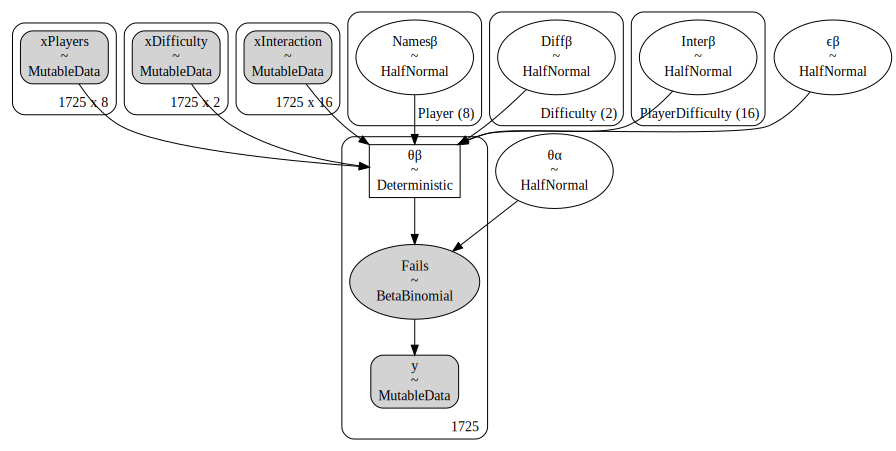

In [6]:
pm.model_to_graphviz(BB2)

In [7]:
with BB2:
    trace2 = pm.sample(
        draws=1000,
        tune=2000,
        # start={
        #     'Namesβ': np.array([1., 1., 1., 1., 1., 1.]), 
        #     'Namesα': np.array([1., 1., 1., 1., 1., 1.]), 
        # }, 
        return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Namesβ, Diffβ, Interβ, ϵβ, θα]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 323 seconds.
The acceptance probability does not match the target. It is 0.8835, but should be close to 0.8. Try to increase the number of tuning steps.


## Display Summary

In [8]:
az.summary(trace2, var_names=["Namesβ", "Diffβ", "Interβ", "ϵβ"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Namesβ[Ca.W],0.891,0.512,0.014,1.756,0.010,0.007,2109.0,1516.0,1.0
Namesβ[Da.M],1.172,0.572,0.035,2.128,0.013,0.009,1863.0,1358.0,1.0
Namesβ[Da.S],0.448,0.341,0.000,1.055,0.006,0.005,2005.0,1273.0,1.0
Namesβ[Ja.F],0.828,0.620,0.002,1.940,0.010,0.007,2519.0,1554.0,1.0
Namesβ[Ka.S],0.722,0.452,0.000,1.475,0.009,0.006,2221.0,1922.0,1.0
Namesβ[Ka.W],0.706,0.430,0.000,1.439,0.009,0.006,1740.0,874.0,1.0
Namesβ[St.S],2.362,0.693,1.048,3.679,0.014,0.010,2613.0,1742.0,1.0
Namesβ[Su.S],1.079,0.639,0.002,2.184,0.012,0.009,2062.0,1046.0,1.0
Diffβ[Easy],2.466,0.581,1.342,3.535,0.012,0.008,2467.0,2478.0,1.0
Diffβ[Hard],1.020,0.545,0.006,1.916,0.011,0.008,2042.0,1397.0,1.0


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

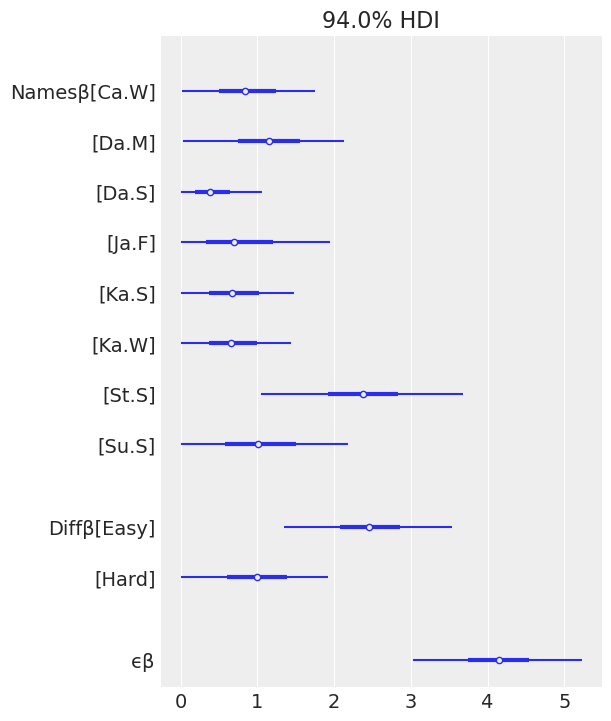

In [9]:
az.plot_forest(trace2, var_names=["Namesβ", "Diffβ", "ϵβ"], combined=True)

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

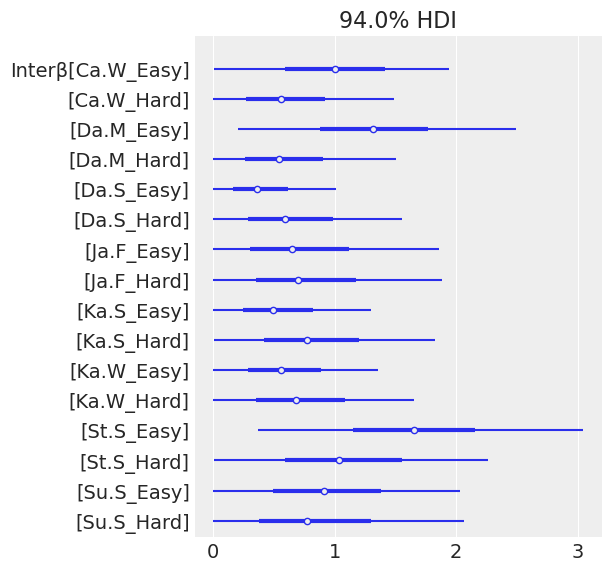

In [10]:
az.plot_forest(trace2, var_names=["Interβ"], combined=True)

## Posterior Predictive

The posterior predictive seems slightly worse when NOT using hyper-priors for Players, Difficulty. 
Maybe there is additional variation to capture by adding 'gender' or 'relationship' variables?

In [22]:
with BB2:
    ppc_data_trace2 = pm.sample_posterior_predictive(trace2, extend_inferencedata=True)

<AxesSubplot:xlabel='Fails / Fails'>

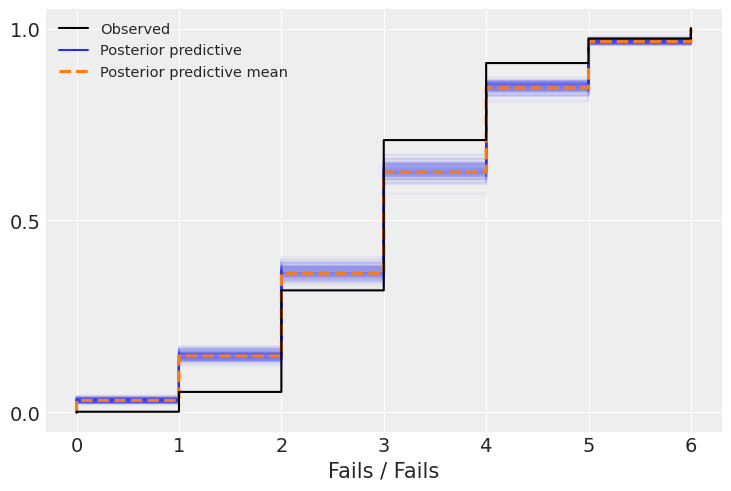

In [82]:
az.plot_ppc(ppc_data_trace2, alpha=0.05, kind="cumulative", num_pp_samples=100)

## Generate Fitted Values

The key here is to use the 'set_data' attribute. Running the model again with the same data causes the model to generate predictions. The previous run generated draws for _parameter_ values. Here we're getting the fitted _response_ values.

In [11]:
with BB2:
    pm.set_data({
        "y" : df2['Fails'].to_numpy(),
        "xPlayers" : playerDummies.to_numpy(),
        "xDifficulty" : difficultyDummies.to_numpy(),
        "xInteraction" : interactionDummies.to_numpy()
    })
    
    y_test = pm.sample_posterior_predictive(trace2)

In [21]:
playerOut = playerDummies.copy()
diffOut = difficultyDummies.copy()
interOut = interactionDummies.copy()

### Players

In [22]:
# Add the fails and the predictions to the player dummies
playerOut['Fails'] = df2['Fails']
playerOut['Predictions'] = y_test.posterior_predictive['Fails'].mean(('chain', 'draw'))
# get columns to aggregate and melt by
cols=playerOut.columns[:-1].to_list()
# melt
playerOut = playerOut.groupby(cols).agg({'Predictions':'mean'}).reset_index()
playerOut = pd.melt(playerOut, id_vars=['Fails','Predictions']).drop('value',axis=1)

### Difficulty

In [28]:
diffOut['Fails'] = df2['Fails']
diffOut['Predictions'] = y_test.posterior_predictive['Fails'].mean(('chain', 'draw'))
cols=diffOut.columns[:-1].to_list()
diffOut = diffOut.groupby(cols).agg({'Predictions':'mean'}).reset_index()
diffOut = pd.melt(diffOut, id_vars=['Fails','Predictions']).drop('value',axis=1)

### Interactions

In [30]:
interOut['Fails'] = df2['Fails']
interOut['Predictions'] = y_test.posterior_predictive['Fails'].mean(('chain', 'draw'))
cols=interOut.columns[:-1].to_list()
interOut = interOut.groupby(cols).agg({'Predictions':'mean'}).reset_index()
interOut = pd.melt(interOut, id_vars=['Fails','Predictions']).drop('value',axis=1)

## Write Output

In [32]:
# write the summary file
az.summary(trace2, var_names=["Namesβ", "Diffβ", "Interβ", "ϵβ"]).to_csv(censoring.model_output, index=False)
# write the fitted values
playerOut.to_csv(censoring.playerOut, index=False)
diffOut.to_csv(censoring.diffOut, index=False)
interOut.to_csv(censoring.interOut, index=False)